In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
print('Libraries imported.')


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


In [2]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
data = BeautifulSoup(response,'html.parser')

borough_table = data.find_all("table")[0]
borough_table_rows = borough_table.find_all('tr')[1:]

Borough_df = pd.DataFrame(columns=['Borough','Population Density (/sq km)'])

In [3]:
for i in borough_table_rows:
    borough_name = i.td.text.strip()
    
    base_url = "https://en.wikipedia.org"
    borough_url = base_url + (i.td.a['href'])
    
    response_2 = requests.get(borough_url).text
    data_2 = BeautifulSoup(response_2,'html.parser')
    
    density = 0
    x = data_2.find_all('tr')
    
    try:
        for i in x:
            try:
                temp_string = i.th.string.strip().split()[-1]
            except AttributeError:
                pass
        
            if(temp_string=='Density'):
                num = (i.td.text.split('(')[1])
                density = int(num.split('/')[0].replace(',',''))
                break
        
        Borough_df = Borough_df.append({'Borough':borough_name,'Population Density (/sq km)':density},ignore_index=True)
        
    except:
        pass

In [4]:
Borough_df = Borough_df.append({'Borough':'Barnet','Population Density (/sq km)':4600},ignore_index=True)
Borough_df = Borough_df.append({'Borough':'Kingston upon Thames','Population Density (/sq km)':4800},ignore_index=True)
Borough_df['Borough'][0] = "Barking and Dagenham"
Borough_df['Borough'][8] = "Greenwich"
Borough_df['Borough'][10] = "Hammersmith and Fulham"

In [5]:
Neighborhood_dict = {'Waltham Forest':'walthamstow','Tower Hamlets':'whitechapel','Redbridge':'wanstead','Newham':'woolwich','Lambeth':'brixton','Hillingdon':'ickenham','Havering':'romford','Haringey':'tottenham','Brent':'wembley','Bexley':'upton'}
Borough_df['Avg Property Price(GBP)'] = 0
for borough in Borough_df['Borough']:
    name = borough.split()[0]
    url = 'https://www.foxtons.co.uk/living-in/'+name
    response_3 = requests.get(url).text
    data_3 = BeautifulSoup(response_3,'html.parser')
    title = data_3.title.text.split()[0]
    if(title!='London'):
        price = int(data_3.find_all(class_='price_headline')[0].text.replace(',','')[1:])
        Borough_df['Avg Property Price(GBP)'][Borough_df['Borough']==borough] = price
    else:
        url = 'https://www.foxtons.co.uk/living-in/'+Neighborhood_dict[borough]
        response_3 = requests.get(url).text
        data_3 = BeautifulSoup(response_3,'html.parser')
        price = int(data_3.find_all(class_='price_headline')[0].text.replace(',','')[1:])
        Borough_df['Avg Property Price(GBP)'][Borough_df['Borough']==borough] = price

C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


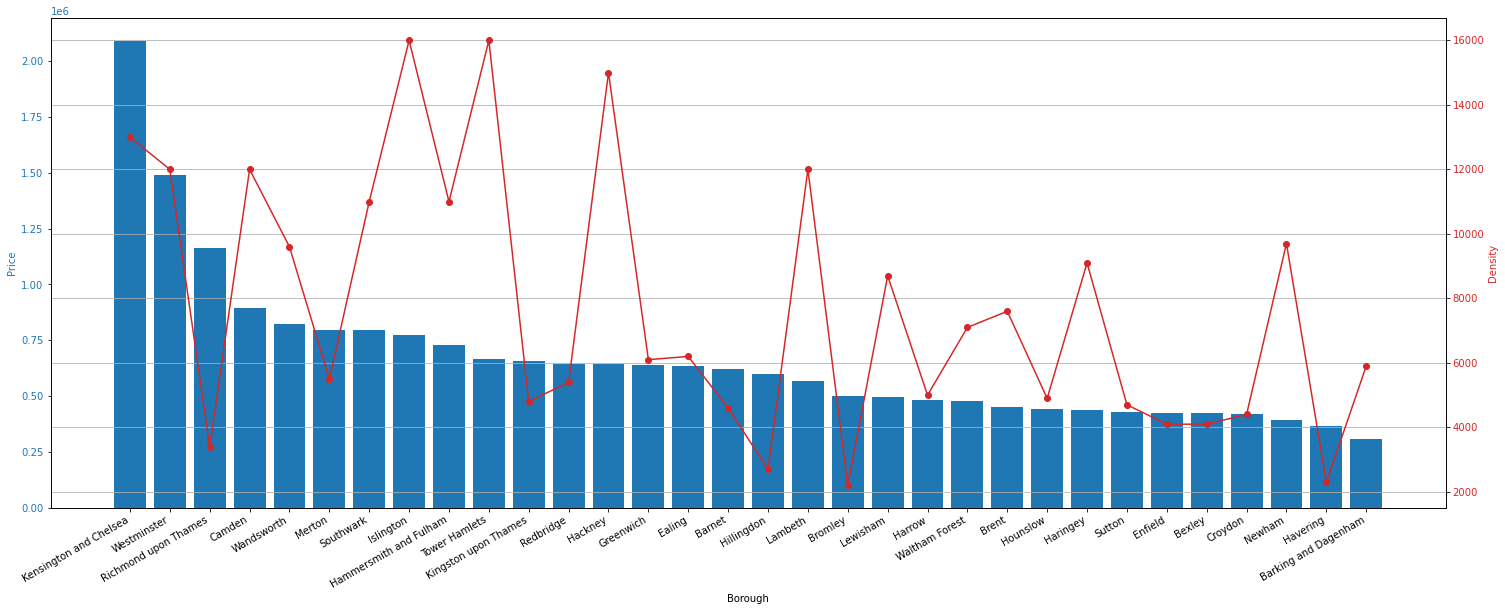

In [22]:
Borough_df.sort_values(by='Avg Property Price(GBP)',ascending=False,inplace=True)
Borough_df.reset_index(inplace=True,drop=True)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Borough')
ax1.set_ylabel('Price', color=color)
ax1.bar(Borough_df['Borough'],Borough_df['Avg Property Price(GBP)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Density', color=color)  # we already handled the x-label with ax1
ax2.plot(Borough_df['Borough'],Borough_df['Population Density (/sq km)'], color=color,marker='o')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate() #rotates the xlabel to precent overlapping
plt.rcParams['figure.figsize'] = (25,25)
plt.grid()
plt.show()

Let's assume the customer's budget lies between GBP 600000 and GBP 900000. Also, we would want the population density to be moderate to high as a low density would mean low footfall and a high density would probably lead to difficulty in finding space to open a restaurant. Refering to the above graph, the <b>London borough of Hammersmith and Fulham</b> seems be a reasonable choice.

In [23]:
HNF_districts = pd.DataFrame(columns=['District','Latitude','Longitude'])

In [40]:
response_district = requests.get('https://en.wikipedia.org/wiki/London_Borough_of_Hammersmith_and_Fulham#Districts').text
data = BeautifulSoup(response_district,'html.parser')

In [41]:
lists = data.find_all('li')
for i in lists[121:134]:
    HNF_districts = HNF_districts.append({'District':i.text.split('(')[0]},ignore_index=True)


In [52]:
for i in HNF_districts['District']:
    address = i + ',London'

    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of', i,'are {}, {}.'.format(latitude, longitude))
    HNF_districts['Latitude'][HNF_districts['District']==i] = latitude
    HNF_districts['Longitude'][HNF_districts['District']==i] = longitude

The geograpical coordinate of Brook Green are 51.4960214, -0.2192533.
The geograpical coordinate of Chelsea Harbour  are 51.47536985, -0.18104674292671608.
The geograpical coordinate of College Park are 51.5311515, -0.2353698.
The geograpical coordinate of East Acton are 51.5173451, -0.248137.
The geograpical coordinate of Fulham are 51.4744221, -0.2060772.
The geograpical coordinate of Hammersmith are 51.4920377, -0.2236401.
The geograpical coordinate of Old Oak Common are 51.5279486, -0.2470894.
The geograpical coordinate of Parsons Green are 51.4750837, -0.201549.
The geograpical coordinate of Sands End are 51.4725454, -0.1871122.
The geograpical coordinate of Shepherd's Bush are 51.505314, -0.2229007.
The geograpical coordinate of Walham Green are 51.4813433, -0.1950367.
The geograpical coordinate of West Kensington are 51.4906622, -0.205916.
The geograpical coordinate of White City are 51.5119347, -0.2242361.


In [53]:
HNF_districts

,District,Latitude,Longitude
0,Brook Green,51.496,-0.219253
1,Chelsea Harbour,51.4754,-0.181047
2,College Park,51.5312,-0.23537
3,East Acton,51.5173,-0.248137
4,Fulham,51.4744,-0.206077
5,Hammersmith,51.492,-0.22364
6,Old Oak Common,51.5279,-0.247089
7,Parsons Green,51.4751,-0.201549
8,Sands End,51.4725,-0.187112
9,Shepherd's Bush,51.5053,-0.222901


In [55]:
location = geolocator.geocode('London,United Kingdom')
latitude_hnf = location.latitude
longitude_hnf = location.longitude

map_hnf = folium.Map(location=[latitude_hnf, longitude_hnf], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(HNF_districts['Latitude'], HNF_districts['Longitude'], HNF_districts['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hnf)  
    
map_hnf

In [183]:
CLIENT_ID = 'WKFAVNAIRLPPY5USSMN31PYXFLYTO1XKLGH04V50RBXVMXO1' # your Foursquare ID
CLIENT_SECRET = 'Z3LRCUNWXAQSKWAN5HCLJVYZIMGFKCWI54WH3BQJFDJQ5ZHB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
RADIUS = 500
SECTION = 'food'

url = 'https://api.foursquare.com/v2/venues/explore'
para = {'radius':RADIUS,'section':SECTION,'client_id':CLIENT_ID,'client_secret':CLIENT_SECRET,'v':VERSION,'limit':500,'llAcc':10}

Neighborhood_df = pd.DataFrame(columns = ['District','Restaurant Name','Category'])



In [184]:
for row in HNF_districts.values:
    try:
        district = row[0]
        para['ll'] = ('{},{}'.format(row[1],row[2]))
        results = requests.get(url,params=para).json()
        for i in results['response']['groups'][0]['items']:
            rest_name = i['venue']['name']
            rest_category = i['venue']['categories'][0]['shortName'] 
            Neighborhood_df = Neighborhood_df.append({'District':district,'Restaurant Name':rest_name,'Category':rest_category},ignore_index=True)
    except IndexError:
        pass

In [185]:
Neighborhood_df.shape

(365, 3)

In [186]:
len(Neighborhood_df['Restaurant Name'].unique())

274

In [187]:
Neighborhood_df = Neighborhood_df[~(Neighborhood_df['Category'].isin(['Restaurant','Office','Advertising Agency','Tour Provider']))]
Neighborhood_df.reset_index(inplace=True,drop=True)

In [188]:
len(Neighborhood_df['Restaurant Name'].unique())

266

In [189]:
Neighborhood_df = Neighborhood_df.drop_duplicates(keep='first',subset='Restaurant Name')

In [190]:
Neighborhood_df.shape

(266, 3)

In [191]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(Neighborhood_df[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['District'] = Neighborhood_df['District'] 

# move neighborhood column to the first column
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]

neighborhood_onehot.head()

,District,American,Asian,BBQ,Bagels,Bakery,Brazilian,Breakfast,Burgers,Burritos,Café,Caribbean,Chinese,Creperie,Deli / Bodega,Dim Sum,Diner,Donuts,English,Falafel,Fast Food,Fish & Chips,Food Court,Food Truck,French,Fried Chicken,Gastropub,German,Greek,Indian,Italian,Japanese,Kebab,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,New American,Persian,Pizza,Portuguese,Salad,Sandwiches,Seafood,South American,Spanish,Steakhouse,Sushi,Tapas,Thai,Turkish,Vegetarian / Vegan,Wings
0,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [201]:
neighborhood_grouped = neighborhood_onehot.groupby('District').sum().reset_index()
neighborhood_grouped

,District,American,Asian,BBQ,Bagels,Bakery,Brazilian,Breakfast,Burgers,Burritos,Café,Caribbean,Chinese,Creperie,Deli / Bodega,Dim Sum,Diner,Donuts,English,Falafel,Fast Food,Fish & Chips,Food Court,Food Truck,French,Fried Chicken,Gastropub,German,Greek,Indian,Italian,Japanese,Kebab,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,New American,Persian,Pizza,Portuguese,Salad,Sandwiches,Seafood,South American,Spanish,Steakhouse,Sushi,Tapas,Thai,Turkish,Vegetarian / Vegan,Wings
0,Brook Green,0,1,0,0,1,0,1,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,3,0,0,1,3,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,2,1,0,1
1,Chelsea Harbour,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,2,0,0,1,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
2,College Park,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,2,0,0,0
3,East Acton,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fulham,0,0,0,0,2,0,0,0,0,5,0,1,0,1,0,0,0,0,0,1,0,0,0,2,0,1,0,0,1,8,1,1,0,1,0,0,0,0,0,2,0,0,1,1,0,1,1,0,0,2,0,0,0
5,Hammersmith,0,0,0,0,1,0,1,4,2,8,0,0,1,1,0,0,1,1,0,3,0,1,1,1,0,0,1,0,2,0,1,0,1,0,0,0,0,0,0,3,0,0,2,0,0,0,0,1,1,2,1,1,0
6,Old Oak Common,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Parsons Green,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,Sands End,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,Shepherd's Bush,2,1,0,2,2,1,1,4,0,7,1,5,2,1,1,1,1,0,3,4,1,0,0,0,1,1,0,1,4,3,1,0,1,1,1,3,0,0,0,2,0,1,2,0,0,0,1,5,1,2,1,0,0


In [246]:
### set number of clusters
kclusters = 3

neighborhood_grouped_clustering = neighborhood_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1])

In [247]:
neighborhood_final = pd.DataFrame(columns = ['District','Cluster'])
neighborhood_final['District'] = neighborhood_grouped['District']
neighborhood_final['Cluster'] = kmeans.labels_
neighborhood_final['Most Common Theme'] = ''
neighborhood_final['2nd Most Common Theme'] = ''
neighborhood_final['3rd Most Common Theme'] = ''
neighborhood_final['4th Most Common Theme'] = ''

In [248]:
neighborhood_final

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
0,Brook Green,0,,,,
1,Chelsea Harbour,1,,,,
2,College Park,1,,,,
3,East Acton,1,,,,
4,Fulham,0,,,,
5,Hammersmith,2,,,,
6,Old Oak Common,1,,,,
7,Parsons Green,1,,,,
8,Sands End,1,,,,
9,Shepherd's Bush,2,,,,


In [249]:
for i in neighborhood_grouped.values:
    maxidx = np.argsort(i[1:])[-1] 
    maxidx_2 = np.argsort(i[1:])[-2] 
    maxidx_3 = np.argsort(i[1:])[-3] 
    maxidx_4 = np.argsort(i[1:])[-4] 
    most_common_theme = (neighborhood_grouped.columns[maxidx+1])
    most_common_theme_2 = (neighborhood_grouped.columns[maxidx_2+1])
    most_common_theme_3 = (neighborhood_grouped.columns[maxidx_3+1])
    most_common_theme_4 = (neighborhood_grouped.columns[maxidx_4+1])
    district = i[0]
    neighborhood_final['Most Common Theme'][neighborhood_final['District']==district] = most_common_theme    
    neighborhood_final['2nd Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_2 
    neighborhood_final['3rd Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_3 
    neighborhood_final['4th Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_4 

C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [251]:
neighborhood_final[neighborhood_final['Cluster']==0]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
0,Brook Green,0,Café,Italian,Gastropub,Thai
4,Fulham,0,Italian,Café,Thai,French
11,West Kensington,0,Café,Italian,Thai,Breakfast


In [252]:
neighborhood_final[neighborhood_final['Cluster']==1]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
1,Chelsea Harbour,1,Sandwiches,Italian,Modern European,Lebanese
2,College Park,1,Thai,Brazilian,Persian,Bakery
3,East Acton,1,Chinese,Bakery,Fish & Chips,Falafel
6,Old Oak Common,1,Modern European,Breakfast,Café,Caribbean
7,Parsons Green,1,Vegetarian / Vegan,Italian,South American,Burgers
8,Sands End,1,Café,Gastropub,Thai,Italian
10,Walham Green,1,Gastropub,Café,Fast Food,Pizza
12,White City,1,Café,New American,Indian,Pizza


In [253]:
neighborhood_final[neighborhood_final['Cluster']==2]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
5,Hammersmith,2,Café,Burgers,Fast Food,Pizza
9,Shepherd's Bush,2,Café,Sushi,Chinese,Indian
